In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, GRU, LSTM
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
#physical_devices = tf.config.experimental.list_physical_devices('GPU')


In [3]:
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
# Step 1: Loading Data
df = pd.read_csv("NLP - ASS4 - weather_prediction_dataset.csv")


In [5]:
df.columns.tolist()

['DATE',
 'MONTH',
 'BASEL_cloud_cover',
 'BASEL_humidity',
 'BASEL_pressure',
 'BASEL_global_radiation',
 'BASEL_precipitation',
 'BASEL_sunshine',
 'BASEL_temp_mean',
 'BASEL_temp_min',
 'BASEL_temp_max',
 'BUDAPEST_cloud_cover',
 'BUDAPEST_humidity',
 'BUDAPEST_pressure',
 'BUDAPEST_global_radiation',
 'BUDAPEST_precipitation',
 'BUDAPEST_sunshine',
 'BUDAPEST_temp_mean',
 'BUDAPEST_temp_max',
 'DE_BILT_cloud_cover',
 'DE_BILT_wind_speed',
 'DE_BILT_wind_gust',
 'DE_BILT_humidity',
 'DE_BILT_pressure',
 'DE_BILT_global_radiation',
 'DE_BILT_precipitation',
 'DE_BILT_sunshine',
 'DE_BILT_temp_mean',
 'DE_BILT_temp_min',
 'DE_BILT_temp_max',
 'DRESDEN_cloud_cover',
 'DRESDEN_wind_speed',
 'DRESDEN_wind_gust',
 'DRESDEN_humidity',
 'DRESDEN_global_radiation',
 'DRESDEN_precipitation',
 'DRESDEN_sunshine',
 'DRESDEN_temp_mean',
 'DRESDEN_temp_min',
 'DRESDEN_temp_max',
 'DUSSELDORF_cloud_cover',
 'DUSSELDORF_wind_speed',
 'DUSSELDORF_wind_gust',
 'DUSSELDORF_humidity',
 'DUSSELDORF_pres

In [ ]:
target = 'TOURS_temp_max'

In [6]:
features = ['TOURS_pressure', 'TOURS_temp_min']


In [7]:
features2 = ['MONTH', 'TOURS_pressure', 'TOURS_temp_min', 'TOURS_global_radiation', 'TOURS_humidity', 'TOURS_wind_speed', 
            'TOURS_precipitation', 'TOURS_temp_mean']


In [8]:
def preprocess(df, features, target):

    train_df = df[df['DATE'] <= 20071231]
    val_df = df[(df['DATE'] >= 20080101) & (df['DATE'] <= 20091231)]
    
    x_train = train_df[features].values
    y_train = train_df[target].values

    x_val = val_df[features].values
    y_val = val_df[target].values
    
    scaler = MinMaxScaler() # (x - xmin) / (xmax - xmin)
    x_train_scaled = scaler.fit_transform(x_train)

    x_val_scaled = scaler.transform(x_val)

    return x_train_scaled, y_train, x_val_scaled, y_val
    


In [9]:
def preprocess2(df, features, target): # different standardization method

    train_df = df[df['DATE'] <= 20071231]
    val_df = df[(df['DATE'] >= 20080101) & (df['DATE'] <= 20091231)]
    
 
    x_train = train_df[features].values
    y_train = train_df[target].values

    x_val = val_df[features].values
    y_val = val_df[target].values
    
    scaler = StandardScaler() # x-Mu/std(x)
    x_train_scaled = scaler.fit_transform(x_train)
    x_val_scaled = scaler.transform(x_val)

    return x_train_scaled, y_train, x_val_scaled, y_val

In [10]:
xtrain, ytrain, xval, yval = preprocess(df, features, target)

In [11]:
xtrain2, ytrain2, xval2, yval2 = preprocess2(df, features2, target)

In [12]:
def plot_loss2(val_loss_list, title=''):
    fig, ax = plt.subplots(figsize=(12, 10))
    for i in range(len(steps)):
        val_loss = val_loss_list[i]
        epochs = range(1, len(val_loss) + 1)
        ax.plot(epochs, val_loss, label=f'Step size: {steps[i]}')
    ax.set_title('Validation loss of ' + title)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.show()

In [13]:
class TimeSeries:
    def __init__(self, step_size, model_type, num_epochs= 100, batch_size= 64, patience= 10):
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.patience = patience # num of iteration valid error doesn't improve to break
        self.verbose = 0 # amount of info on screen
        self.step_size = step_size
        self.model_type = model_type
        
    def fit(self, X_train, y_train, X_val, y_val):
        X_train_seq, y_train_seq = [], []
        for i in range(self.step_size, len(X_train)):
            X_train_seq.append(X_train[i-self.step_size:i])
            y_train_seq.append(y_train[i])
        X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)

        X_val_seq, y_val_seq = [], []
        for i in range(self.step_size, len(X_val)):
            X_val_seq.append(X_val[i-self.step_size:i])
            y_val_seq.append(y_val[i])
        X_val_seq, y_val_seq = np.array(X_val_seq), np.array(y_val_seq)

        model = Sequential()
        if self.model_type == 'RNN':
            model.add(SimpleRNN(32, input_shape=(self.step_size, X_train_seq.shape[2]), return_sequences=True))
            model.add(SimpleRNN(16))
        elif self.model_type == 'GRU':
            model.add(GRU(32, input_shape=(self.step_size, X_train_seq.shape[2]), return_sequences=True))
            model.add(GRU(16))
        elif self.model_type == 'LSTM':
            model.add(LSTM(32, input_shape=(self.step_size, X_train_seq.shape[2]), return_sequences=True))
            model.add(LSTM(16))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(1))

        model.compile(loss='mse', optimizer='adam')
        early_stopping = EarlyStopping(patience=self.patience, verbose=self.verbose, restore_best_weights=True)
        
        #with tf.device('/device:GPU:0'):
            
        history = model.fit(X_train_seq, y_train_seq, epochs=self.num_epochs, batch_size=self.batch_size,
                            validation_data=(X_val_seq, y_val_seq), callbacks=[early_stopping])
        
        print(f'\n\n {self.model_type} with step size {self.step_size} - Train Loss: {history.history["loss"][-1]:.4f} - '
              f'Val Loss: {history.history["val_loss"][-1]:.4f} \n\n')
         
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']

        return history, train_loss, val_loss

       
        

# **steps= [40,50,60],batch_size=32,num_epoochs=200,patience=15**

---



---



Epoch 1/200
91/91 [==============================] - 6s 60ms/step - loss: 294.2641 - val_loss: 210.4088
Epoch 2/200
91/91 [==============================] - 5s 54ms/step - loss: 160.2029 - val_loss: 112.6545
Epoch 3/200
91/91 [==============================] - 6s 61ms/step - loss: 88.9320 - val_loss: 66.2453
Epoch 4/200
91/91 [==============================] - 6s 63ms/step - loss: 59.8737 - val_loss: 39.0737
Epoch 5/200
91/91 [==============================] - 6s 69ms/step - loss: 30.2011 - val_loss: 18.9066
Epoch 6/200
91/91 [==============================] - 5s 54ms/step - loss: 18.1316 - val_loss: 12.4652
Epoch 7/200
91/91 [==============================] - 5s 56ms/step - loss: 13.9467 - val_loss: 11.0948
Epoch 8/200
91/91 [==============================] - 5s 51ms/step - loss: 19.5035 - val_loss: 11.0847
Epoch 9/200
91/91 [==============================] - 5s 57ms/step - loss: 13.8581 - val_loss: 9.9167
Epoch 10/200
91/91 [==============================] - 5s 54ms/step - loss: 18.8

Epoch 82/200
91/91 [==============================] - 5s 52ms/step - loss: 6.5147 - val_loss: 7.5896
Epoch 83/200
91/91 [==============================] - 5s 55ms/step - loss: 6.5333 - val_loss: 7.0850
Epoch 84/200
91/91 [==============================] - 5s 59ms/step - loss: 6.5118 - val_loss: 7.2302
Epoch 85/200
91/91 [==============================] - 5s 57ms/step - loss: 6.4954 - val_loss: 7.1191
Epoch 86/200
91/91 [==============================] - 5s 54ms/step - loss: 6.5030 - val_loss: 7.1680
Epoch 87/200
91/91 [==============================] - 5s 53ms/step - loss: 6.4969 - val_loss: 7.4343
Epoch 88/200
91/91 [==============================] - 5s 51ms/step - loss: 6.4572 - val_loss: 7.0016
Epoch 89/200
91/91 [==============================] - 4s 48ms/step - loss: 6.3375 - val_loss: 6.8880
Epoch 90/200
91/91 [==============================] - 5s 51ms/step - loss: 6.2776 - val_loss: 6.8576
Epoch 91/200
91/91 [==============================] - 5s 52ms/step - loss: 6.3341 - val_los

90/90 [==============================] - 7s 78ms/step - loss: 6.0201 - val_loss: 6.9772
Epoch 47/200
90/90 [==============================] - 7s 74ms/step - loss: 6.0422 - val_loss: 6.9416
Epoch 48/200
90/90 [==============================] - 6s 71ms/step - loss: 5.8888 - val_loss: 6.8208
Epoch 49/200
90/90 [==============================] - 6s 70ms/step - loss: 5.8970 - val_loss: 6.8338
Epoch 50/200
90/90 [==============================] - 6s 70ms/step - loss: 5.9451 - val_loss: 6.8444
Epoch 51/200
90/90 [==============================] - 7s 72ms/step - loss: 5.8612 - val_loss: 7.0244
Epoch 52/200
90/90 [==============================] - 7s 73ms/step - loss: 5.7178 - val_loss: 7.0422
Epoch 53/200
90/90 [==============================] - 7s 77ms/step - loss: 5.7733 - val_loss: 6.8807
Epoch 54/200
90/90 [==============================] - 7s 81ms/step - loss: 5.8448 - val_loss: 7.0063
Epoch 55/200
90/90 [==============================] - 8s 85ms/step - loss: 5.7021 - val_loss: 7.1055


 

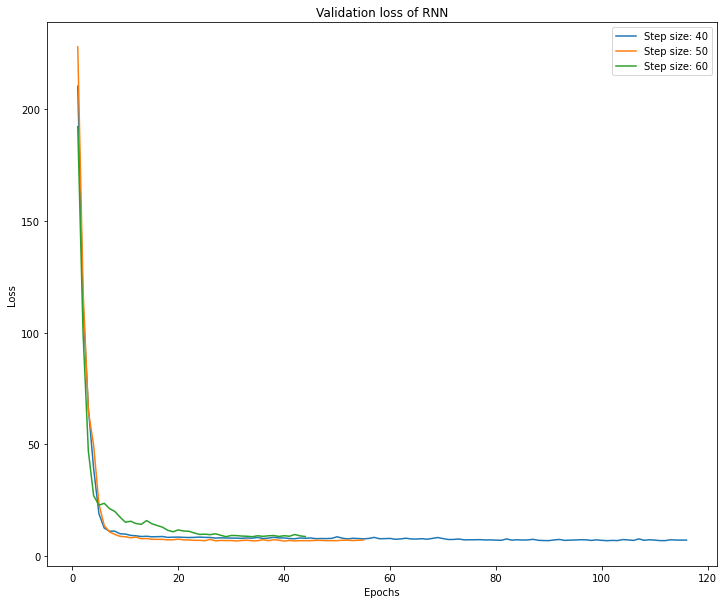

In [23]:
steps= [40,50,60]
val_loss_list = []
for i in steps:
    model = TimeSeries(step_size=i, model_type='RNN', num_epochs=200, batch_size=32, patience=15)
    history, train_loss, val_loss = model.fit(xtrain2, ytrain2, xval2, yval2)
    val_loss_list.append(val_loss)

plot_loss2(val_loss_list, 'RNN')


Epoch 1/200
91/91 [==============================] - 3s 14ms/step - loss: 215.9514 - val_loss: 104.9670
Epoch 2/200
91/91 [==============================] - 1s 9ms/step - loss: 79.8852 - val_loss: 52.7748
Epoch 3/200
91/91 [==============================] - 1s 9ms/step - loss: 54.2816 - val_loss: 37.3979
Epoch 4/200
91/91 [==============================] - 1s 9ms/step - loss: 36.9483 - val_loss: 21.8575
Epoch 5/200
91/91 [==============================] - 1s 9ms/step - loss: 20.5952 - val_loss: 12.4467
Epoch 6/200
91/91 [==============================] - 1s 9ms/step - loss: 13.2475 - val_loss: 10.3680
Epoch 7/200
91/91 [==============================] - 1s 10ms/step - loss: 11.1605 - val_loss: 9.2327
Epoch 8/200
91/91 [==============================] - 1s 9ms/step - loss: 10.0949 - val_loss: 8.3405
Epoch 9/200
91/91 [==============================] - 1s 9ms/step - loss: 9.4486 - val_loss: 8.0548
Epoch 10/200
91/91 [==============================] - 1s 9ms/step - loss: 8.9019 - val_loss

90/90 [==============================] - 1s 9ms/step - loss: 6.1561 - val_loss: 5.8611
Epoch 30/200
90/90 [==============================] - 1s 9ms/step - loss: 6.0760 - val_loss: 5.8164
Epoch 31/200
90/90 [==============================] - 1s 10ms/step - loss: 6.1093 - val_loss: 5.6729
Epoch 32/200
90/90 [==============================] - 1s 10ms/step - loss: 6.1022 - val_loss: 5.8717
Epoch 33/200
90/90 [==============================] - 1s 10ms/step - loss: 6.0648 - val_loss: 6.0035
Epoch 34/200
90/90 [==============================] - 1s 10ms/step - loss: 6.0174 - val_loss: 5.5751
Epoch 35/200
90/90 [==============================] - 1s 10ms/step - loss: 6.0969 - val_loss: 5.7107
Epoch 36/200
90/90 [==============================] - 1s 10ms/step - loss: 5.9271 - val_loss: 5.5749
Epoch 37/200
90/90 [==============================] - 1s 9ms/step - loss: 5.9630 - val_loss: 5.9967
Epoch 38/200
90/90 [==============================] - 1s 8ms/step - loss: 5.9591 - val_loss: 5.7493
Epoch 3

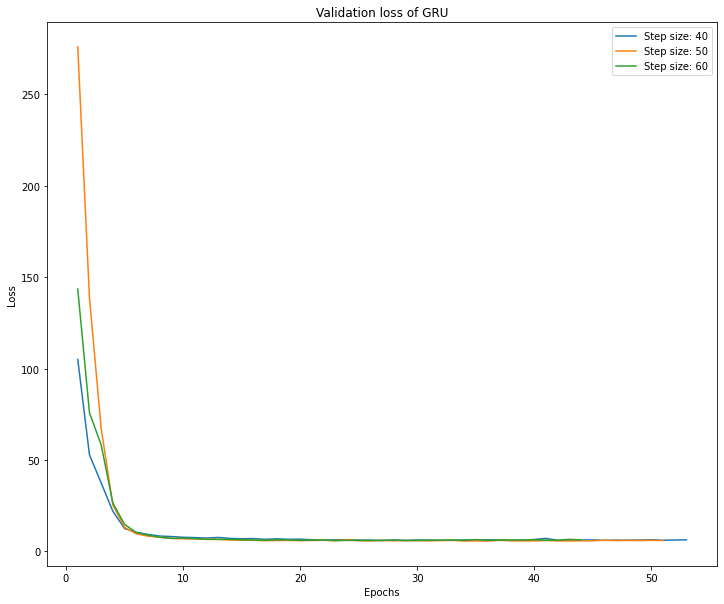

In [21]:
steps= [40,50,60]
val_loss_list = []
for i in steps:
    model = TimeSeries(step_size=i, model_type='GRU', num_epochs=200, batch_size=32, patience=15)
    history, train_loss, val_loss = model.fit(xtrain2, ytrain2, xval2, yval2)
    val_loss_list.append(val_loss)

plot_loss2(val_loss_list, 'GRU')


Epoch 1/200
91/91 [==============================] - 3s 13ms/step - loss: 251.3902 - val_loss: 163.7382
Epoch 2/200
91/91 [==============================] - 1s 9ms/step - loss: 131.7784 - val_loss: 100.2509
Epoch 3/200
91/91 [==============================] - 1s 8ms/step - loss: 85.9242 - val_loss: 68.1895
Epoch 4/200
91/91 [==============================] - 1s 7ms/step - loss: 62.0099 - val_loss: 39.9621
Epoch 5/200
91/91 [==============================] - 1s 7ms/step - loss: 33.7628 - val_loss: 22.0850
Epoch 6/200
91/91 [==============================] - 1s 9ms/step - loss: 21.5500 - val_loss: 15.1150
Epoch 7/200
91/91 [==============================] - 1s 9ms/step - loss: 16.3172 - val_loss: 11.6961
Epoch 8/200
91/91 [==============================] - 1s 9ms/step - loss: 13.6068 - val_loss: 10.3313
Epoch 9/200
91/91 [==============================] - 1s 9ms/step - loss: 11.9786 - val_loss: 9.1563
Epoch 10/200
91/91 [==============================] - 1s 9ms/step - loss: 10.8696 - val

Epoch 28/200
90/90 [==============================] - 1s 10ms/step - loss: 6.5725 - val_loss: 6.7658
Epoch 29/200
90/90 [==============================] - 1s 10ms/step - loss: 6.5103 - val_loss: 6.7708
Epoch 30/200
90/90 [==============================] - 1s 10ms/step - loss: 6.3795 - val_loss: 7.3796
Epoch 31/200
90/90 [==============================] - 1s 10ms/step - loss: 6.4786 - val_loss: 6.5744
Epoch 32/200
90/90 [==============================] - 1s 10ms/step - loss: 6.2087 - val_loss: 6.8408
Epoch 33/200
90/90 [==============================] - 1s 10ms/step - loss: 6.1678 - val_loss: 6.6510
Epoch 34/200
90/90 [==============================] - 1s 10ms/step - loss: 6.1036 - val_loss: 6.5375
Epoch 35/200
90/90 [==============================] - 1s 11ms/step - loss: 6.0495 - val_loss: 6.7871
Epoch 36/200
90/90 [==============================] - 1s 10ms/step - loss: 6.0048 - val_loss: 6.4933
Epoch 37/200
90/90 [==============================] - 1s 10ms/step - loss: 5.8591 - val_los

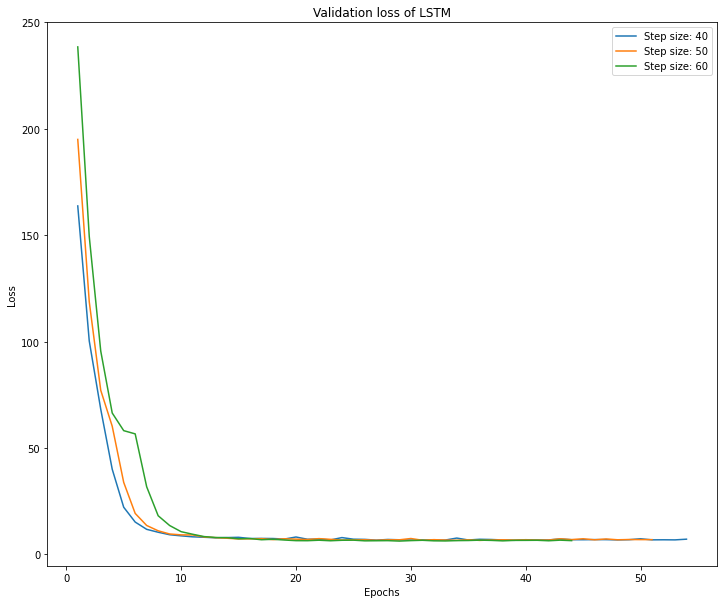

In [22]:
steps= [40,50,60]
val_loss_list = []
for i in steps:
    model = TimeSeries(step_size=i, model_type='LSTM', num_epochs=200, batch_size=32, patience=15)
    history, train_loss, val_loss = model.fit(xtrain2, ytrain2, xval2, yval2)
    val_loss_list.append(val_loss)

plot_loss2(val_loss_list, 'LSTM')


# **step size=[100,150,300] ,batch_size=32,num_epoochs=200,patience=15**

Epoch 1/200
89/89 [==============================] - 13s 142ms/step - loss: 183.5041 - val_loss: 95.2685
Epoch 2/200
89/89 [==============================] - 13s 141ms/step - loss: 65.8550 - val_loss: 47.6685
Epoch 3/200
89/89 [==============================] - 13s 141ms/step - loss: 33.3219 - val_loss: 17.4877
Epoch 4/200
89/89 [==============================] - 12s 132ms/step - loss: 17.6829 - val_loss: 11.7188
Epoch 5/200
89/89 [==============================] - 12s 136ms/step - loss: 13.2681 - val_loss: 10.5536
Epoch 6/200
89/89 [==============================] - 12s 138ms/step - loss: 11.6725 - val_loss: 9.5748
Epoch 7/200
89/89 [==============================] - 13s 146ms/step - loss: 10.6828 - val_loss: 8.9686
Epoch 8/200
89/89 [==============================] - 12s 138ms/step - loss: 10.0369 - val_loss: 8.7258
Epoch 9/200
89/89 [==============================] - 13s 142ms/step - loss: 9.6239 - val_loss: 8.8259
Epoch 10/200
89/89 [==============================] - 12s 131ms/step

89/89 [==============================] - 11s 128ms/step - loss: 5.9743 - val_loss: 7.0338
Epoch 81/200
89/89 [==============================] - 11s 121ms/step - loss: 5.7408 - val_loss: 7.0213
Epoch 82/200
89/89 [==============================] - 11s 129ms/step - loss: 5.7734 - val_loss: 6.3649
Epoch 83/200
89/89 [==============================] - 12s 137ms/step - loss: 5.7510 - val_loss: 6.9177
Epoch 84/200
89/89 [==============================] - 13s 141ms/step - loss: 5.8093 - val_loss: 6.6284
Epoch 85/200
89/89 [==============================] - 11s 128ms/step - loss: 5.6787 - val_loss: 6.4175
Epoch 86/200
89/89 [==============================] - 11s 127ms/step - loss: 5.8394 - val_loss: 6.3635
Epoch 87/200
89/89 [==============================] - 12s 137ms/step - loss: 5.6525 - val_loss: 7.0480
Epoch 88/200
89/89 [==============================] - 12s 135ms/step - loss: 5.6631 - val_loss: 6.4724
Epoch 89/200
89/89 [==============================] - 12s 131ms/step - loss: 5.6495 - 

86/86 [==============================] - 22s 253ms/step - loss: 7.8059 - val_loss: 7.5539
Epoch 19/200
86/86 [==============================] - 23s 268ms/step - loss: 7.8285 - val_loss: 7.2805
Epoch 20/200
86/86 [==============================] - 23s 265ms/step - loss: 7.6341 - val_loss: 7.1973
Epoch 21/200
86/86 [==============================] - 22s 255ms/step - loss: 7.5257 - val_loss: 7.0286
Epoch 22/200
86/86 [==============================] - 23s 272ms/step - loss: 7.3413 - val_loss: 7.2382
Epoch 23/200
86/86 [==============================] - 22s 251ms/step - loss: 7.5080 - val_loss: 7.2280
Epoch 24/200
86/86 [==============================] - 22s 256ms/step - loss: 7.3679 - val_loss: 6.9654
Epoch 25/200
86/86 [==============================] - 22s 261ms/step - loss: 7.2545 - val_loss: 6.8595
Epoch 26/200
86/86 [==============================] - 23s 264ms/step - loss: 7.0635 - val_loss: 6.9216
Epoch 27/200
86/86 [==============================] - 22s 259ms/step - loss: 7.0147 - 

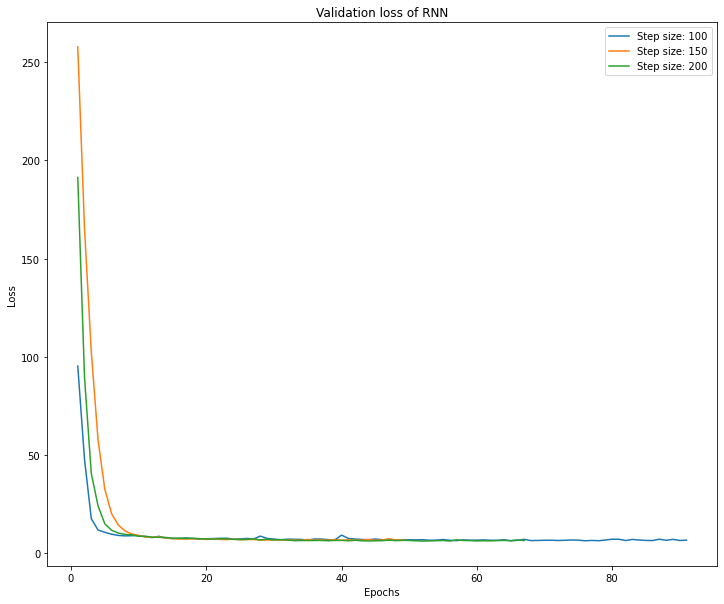

In [18]:
steps= [100, 150, 200]
val_loss_list = []
for i in steps:
    model = TimeSeries(step_size=i, model_type='RNN', num_epochs=200, batch_size=32, patience=15)
    history, train_loss, val_loss = model.fit(xtrain2, ytrain2, xval2, yval2)
    val_loss_list.append(val_loss)

plot_loss2(val_loss_list, 'RNN')


Epoch 1/200
89/89 [==============================] - 3s 22ms/step - loss: 327.9732 - val_loss: 310.0398
Epoch 2/200
89/89 [==============================] - 1s 16ms/step - loss: 224.6775 - val_loss: 167.9974
Epoch 3/200
89/89 [==============================] - 1s 16ms/step - loss: 125.5497 - val_loss: 99.1861
Epoch 4/200
89/89 [==============================] - 1s 16ms/step - loss: 79.9688 - val_loss: 68.2055
Epoch 5/200
89/89 [==============================] - 1s 16ms/step - loss: 60.6561 - val_loss: 42.4804
Epoch 6/200
89/89 [==============================] - 1s 16ms/step - loss: 33.4499 - val_loss: 21.9349
Epoch 7/200
89/89 [==============================] - 2s 17ms/step - loss: 20.2401 - val_loss: 14.4610
Epoch 8/200
89/89 [==============================] - 1s 16ms/step - loss: 14.8400 - val_loss: 10.9770
Epoch 9/200
89/89 [==============================] - 1s 16ms/step - loss: 12.1616 - val_loss: 9.2709
Epoch 10/200
89/89 [==============================] - 1s 16ms/step - loss: 10.

87/87 [==============================] - 2s 23ms/step - loss: 6.3261 - val_loss: 6.1474
Epoch 39/200
87/87 [==============================] - 2s 24ms/step - loss: 6.2962 - val_loss: 5.9958
Epoch 40/200
87/87 [==============================] - 2s 23ms/step - loss: 6.2683 - val_loss: 5.9452
Epoch 41/200
87/87 [==============================] - 2s 24ms/step - loss: 6.2125 - val_loss: 5.8987
Epoch 42/200
87/87 [==============================] - 2s 24ms/step - loss: 6.2081 - val_loss: 5.9718
Epoch 43/200
87/87 [==============================] - 2s 25ms/step - loss: 6.1718 - val_loss: 5.9496
Epoch 44/200
87/87 [==============================] - 2s 25ms/step - loss: 6.3126 - val_loss: 5.8384
Epoch 45/200
87/87 [==============================] - 2s 25ms/step - loss: 6.0869 - val_loss: 6.1391
Epoch 46/200
87/87 [==============================] - 2s 24ms/step - loss: 6.0793 - val_loss: 6.1371
Epoch 47/200
87/87 [==============================] - 2s 25ms/step - loss: 6.2559 - val_loss: 6.0864
Epo

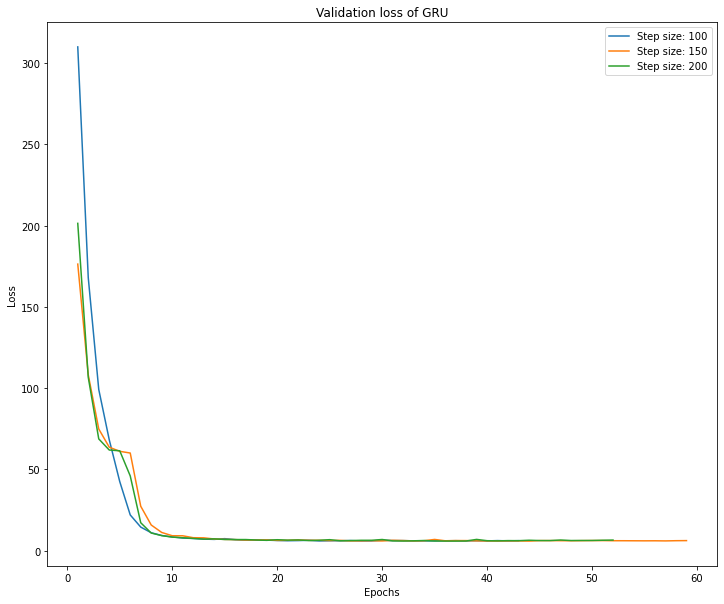

In [19]:
steps= [100, 150, 200]
val_loss_list = []
for i in steps:
    model = TimeSeries(step_size=i, model_type='GRU', num_epochs=200, batch_size=32, patience=15)
    history, train_loss, val_loss = model.fit(xtrain2, ytrain2, xval2, yval2)
    val_loss_list.append(val_loss)

plot_loss2(val_loss_list, 'GRU')


Epoch 1/200
89/89 [==============================] - 3s 18ms/step - loss: 246.8096 - val_loss: 149.2462
Epoch 2/200
89/89 [==============================] - 1s 14ms/step - loss: 98.2891 - val_loss: 65.5309
Epoch 3/200
89/89 [==============================] - 1s 14ms/step - loss: 41.7563 - val_loss: 20.8044
Epoch 4/200
89/89 [==============================] - 1s 13ms/step - loss: 19.3357 - val_loss: 13.2677
Epoch 5/200
89/89 [==============================] - 1s 14ms/step - loss: 14.4741 - val_loss: 10.7031
Epoch 6/200
89/89 [==============================] - 1s 15ms/step - loss: 12.3835 - val_loss: 9.6225
Epoch 7/200
89/89 [==============================] - 1s 15ms/step - loss: 10.9320 - val_loss: 8.9149
Epoch 8/200
89/89 [==============================] - 1s 15ms/step - loss: 9.9765 - val_loss: 8.4326
Epoch 9/200
89/89 [==============================] - 1s 16ms/step - loss: 9.4512 - val_loss: 8.1364
Epoch 10/200
89/89 [==============================] - 1s 15ms/step - loss: 8.7787 - va

87/87 [==============================] - 2s 21ms/step - loss: 5.9840 - val_loss: 6.8564
Epoch 41/200
87/87 [==============================] - 2s 20ms/step - loss: 5.9935 - val_loss: 7.0782
Epoch 42/200
87/87 [==============================] - 2s 21ms/step - loss: 5.7831 - val_loss: 6.8907
Epoch 43/200
87/87 [==============================] - 2s 21ms/step - loss: 5.7632 - val_loss: 6.6622
Epoch 44/200
87/87 [==============================] - 2s 21ms/step - loss: 5.7955 - val_loss: 7.0711


 LSTM with step size 150 - Train Loss: 5.7955 - Val Loss: 7.0711 


Epoch 1/200
86/86 [==============================] - 4s 28ms/step - loss: 252.2498 - val_loss: 149.1167
Epoch 2/200
86/86 [==============================] - 2s 27ms/step - loss: 106.5999 - val_loss: 75.5531
Epoch 3/200
86/86 [==============================] - 2s 26ms/step - loss: 64.1214 - val_loss: 51.2892
Epoch 4/200
86/86 [==============================] - 2s 24ms/step - loss: 33.0942 - val_loss: 20.7296
Epoch 5/200
86/86 [========

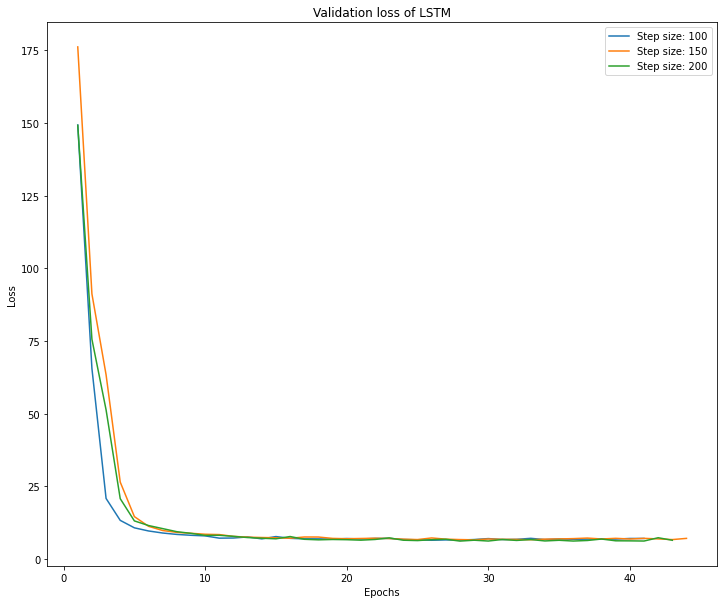

In [20]:
steps= [100, 150, 200]
val_loss_list = []
for i in steps:
    model = TimeSeries(step_size=i, model_type='LSTM', num_epochs=200, batch_size=32, patience=15)
    history, train_loss, val_loss = model.fit(xtrain2, ytrain2, xval2, yval2)
    val_loss_list.append(val_loss)

plot_loss2(val_loss_list, 'LSTM')


# **steps= [32,128,256],batch_size=32,num_epoochs=200,patience=15**

---



---


Epoch 1/200
91/91 [==============================] - 5s 47ms/step - loss: 245.8543 - val_loss: 144.8578
Epoch 2/200
91/91 [==============================] - 4s 48ms/step - loss: 106.6120 - val_loss: 70.1290
Epoch 3/200
91/91 [==============================] - 4s 42ms/step - loss: 59.4228 - val_loss: 51.4631
Epoch 4/200
91/91 [==============================] - 4s 48ms/step - loss: 34.3234 - val_loss: 19.6288
Epoch 5/200
91/91 [==============================] - 4s 48ms/step - loss: 18.0947 - val_loss: 14.2029
Epoch 6/200
91/91 [==============================] - 4s 44ms/step - loss: 14.2880 - val_loss: 10.0803
Epoch 7/200
91/91 [==============================] - 4s 44ms/step - loss: 11.8916 - val_loss: 9.4508
Epoch 8/200
91/91 [==============================] - 4s 44ms/step - loss: 10.7751 - val_loss: 8.9025
Epoch 9/200
91/91 [==============================] - 4s 41ms/step - loss: 10.0937 - val_loss: 8.2774
Epoch 10/200
91/91 [==============================] - 4s 42ms/step - loss: 9.6677 

88/88 [==============================] - 16s 187ms/step - loss: 181.1744 - val_loss: 144.5900
Epoch 3/200
88/88 [==============================] - 16s 184ms/step - loss: 106.0537 - val_loss: 74.6488
Epoch 4/200
88/88 [==============================] - 16s 185ms/step - loss: 55.3986 - val_loss: 38.0708
Epoch 5/200
88/88 [==============================] - 17s 191ms/step - loss: 34.2091 - val_loss: 30.3443
Epoch 6/200
88/88 [==============================] - 16s 180ms/step - loss: 27.8681 - val_loss: 22.9902
Epoch 7/200
88/88 [==============================] - 17s 192ms/step - loss: 25.2671 - val_loss: 24.9392
Epoch 8/200
88/88 [==============================] - 17s 196ms/step - loss: 27.3449 - val_loss: 24.2077
Epoch 9/200
88/88 [==============================] - 17s 195ms/step - loss: 21.7024 - val_loss: 18.5765
Epoch 10/200
88/88 [==============================] - 17s 191ms/step - loss: 20.3590 - val_loss: 17.4659
Epoch 11/200
88/88 [==============================] - 16s 182ms/step - l

88/88 [==============================] - 16s 183ms/step - loss: 6.3935 - val_loss: 6.5686
Epoch 82/200
88/88 [==============================] - 15s 165ms/step - loss: 6.4527 - val_loss: 6.5969
Epoch 83/200
88/88 [==============================] - 15s 167ms/step - loss: 6.4405 - val_loss: 6.7205
Epoch 84/200
88/88 [==============================] - 17s 193ms/step - loss: 6.4431 - val_loss: 6.5210
Epoch 85/200
88/88 [==============================] - 17s 198ms/step - loss: 6.3674 - val_loss: 6.8719
Epoch 86/200
88/88 [==============================] - 17s 195ms/step - loss: 6.4966 - val_loss: 6.9844
Epoch 87/200
88/88 [==============================] - 17s 190ms/step - loss: 6.3502 - val_loss: 6.3909
Epoch 88/200
88/88 [==============================] - 17s 197ms/step - loss: 6.3349 - val_loss: 7.2341
Epoch 89/200
88/88 [==============================] - 18s 200ms/step - loss: 6.3895 - val_loss: 6.5748
Epoch 90/200
88/88 [==============================] - 18s 203ms/step - loss: 6.4124 - 

84/84 [==============================] - 31s 373ms/step - loss: 8.4931 - val_loss: 8.1998
Epoch 58/200
84/84 [==============================] - 30s 360ms/step - loss: 8.5484 - val_loss: 7.7286
Epoch 59/200
84/84 [==============================] - 29s 350ms/step - loss: 8.2190 - val_loss: 8.1713
Epoch 60/200
84/84 [==============================] - 28s 332ms/step - loss: 8.0148 - val_loss: 7.7301
Epoch 61/200
84/84 [==============================] - 29s 349ms/step - loss: 7.9514 - val_loss: 7.6508
Epoch 62/200
84/84 [==============================] - 29s 344ms/step - loss: 7.7864 - val_loss: 7.6222
Epoch 63/200
84/84 [==============================] - 30s 363ms/step - loss: 7.7336 - val_loss: 7.4469
Epoch 64/200
84/84 [==============================] - 29s 348ms/step - loss: 7.7572 - val_loss: 7.3925
Epoch 65/200
84/84 [==============================] - 30s 364ms/step - loss: 8.3559 - val_loss: 9.1122
Epoch 66/200
84/84 [==============================] - 31s 371ms/step - loss: 8.2553 - 

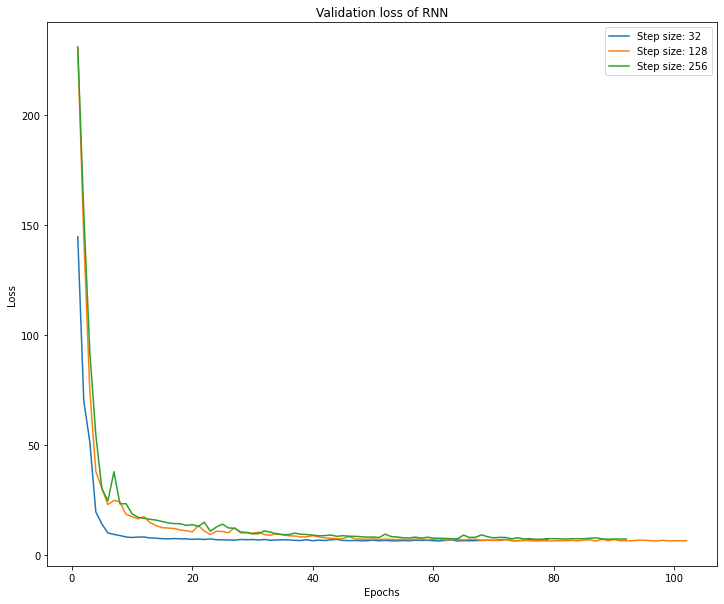

In [16]:
steps= [32, 128, 256]
val_loss_list = []
for i in steps:
    model = TimeSeries(step_size=i, model_type='RNN', num_epochs=200, batch_size=32, patience=15)
    history, train_loss, val_loss = model.fit(xtrain2, ytrain2, xval2, yval2)
    val_loss_list.append(val_loss)

plot_loss2(val_loss_list, 'RNN')

Epoch 1/200
91/91 [==============================] - 4s 30ms/step - loss: 269.6466 - val_loss: 182.5129
Epoch 2/200
91/91 [==============================] - 3s 29ms/step - loss: 133.4955 - val_loss: 87.9832
Epoch 3/200
91/91 [==============================] - 3s 29ms/step - loss: 71.0817 - val_loss: 46.3076
Epoch 4/200
91/91 [==============================] - 2s 27ms/step - loss: 34.3900 - val_loss: 20.2167
Epoch 5/200
91/91 [==============================] - 3s 28ms/step - loss: 18.9379 - val_loss: 12.3553
Epoch 6/200
91/91 [==============================] - 2s 27ms/step - loss: 13.4875 - val_loss: 9.4018
Epoch 7/200
91/91 [==============================] - 3s 29ms/step - loss: 11.0537 - val_loss: 8.8815
Epoch 8/200
91/91 [==============================] - 3s 28ms/step - loss: 9.8659 - val_loss: 7.7002
Epoch 9/200
91/91 [==============================] - 3s 28ms/step - loss: 9.0255 - val_loss: 7.4535
Epoch 10/200
91/91 [==============================] - 3s 28ms/step - loss: 8.5658 - v

88/88 [==============================] - 3s 32ms/step - loss: 5.7342 - val_loss: 6.3573
Epoch 37/200
88/88 [==============================] - 3s 34ms/step - loss: 5.6604 - val_loss: 6.2085
Epoch 38/200
88/88 [==============================] - 3s 33ms/step - loss: 5.6520 - val_loss: 6.3928
Epoch 39/200
88/88 [==============================] - 3s 30ms/step - loss: 5.6826 - val_loss: 6.9617
Epoch 40/200
88/88 [==============================] - 3s 33ms/step - loss: 5.6456 - val_loss: 6.6833
Epoch 41/200
88/88 [==============================] - 3s 32ms/step - loss: 5.5378 - val_loss: 6.3519
Epoch 42/200
88/88 [==============================] - 3s 30ms/step - loss: 5.5356 - val_loss: 6.5296
Epoch 43/200
88/88 [==============================] - 3s 29ms/step - loss: 5.5064 - val_loss: 6.4070
Epoch 44/200
88/88 [==============================] - 3s 31ms/step - loss: 5.4800 - val_loss: 6.5658
Epoch 45/200
88/88 [==============================] - 3s 34ms/step - loss: 5.3371 - val_loss: 6.8695
Epo

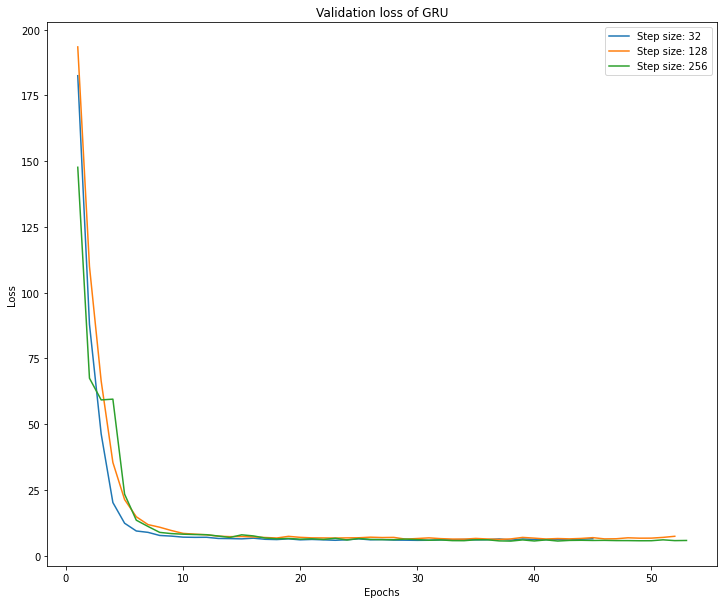

In [15]:

steps= [32, 128, 256]
val_loss_list = []
for i in steps:
    model = TimeSeries(step_size=i, model_type='GRU', num_epochs=200, batch_size=32, patience=15)
    history, train_loss, val_loss = model.fit(xtrain2, ytrain2, xval2, yval2)
    val_loss_list.append(val_loss)

plot_loss2(val_loss_list, 'GRU')

Epoch 1/200
91/91 [==============================] - 5s 24ms/step - loss: 313.9776 - val_loss: 264.7964
Epoch 2/200
91/91 [==============================] - 2s 18ms/step - loss: 191.2392 - val_loss: 135.8512
Epoch 3/200
91/91 [==============================] - 2s 18ms/step - loss: 109.5889 - val_loss: 81.9728
Epoch 4/200
91/91 [==============================] - 2s 19ms/step - loss: 70.6762 - val_loss: 48.9237
Epoch 5/200
91/91 [==============================] - 2s 18ms/step - loss: 40.9168 - val_loss: 26.9749
Epoch 6/200
91/91 [==============================] - 2s 18ms/step - loss: 25.8001 - val_loss: 17.8359
Epoch 7/200
91/91 [==============================] - 2s 19ms/step - loss: 19.2704 - val_loss: 14.1721
Epoch 8/200
91/91 [==============================] - 2s 18ms/step - loss: 16.0073 - val_loss: 12.4451
Epoch 9/200
91/91 [==============================] - 2s 19ms/step - loss: 14.4141 - val_loss: 11.5824
Epoch 10/200
91/91 [==============================] - 2s 18ms/step - loss: 12

88/88 [==============================] - 4s 49ms/step - loss: 6.3464 - val_loss: 6.5164
Epoch 34/200
88/88 [==============================] - 5s 57ms/step - loss: 6.2916 - val_loss: 6.5433
Epoch 35/200
88/88 [==============================] - 5s 60ms/step - loss: 6.2259 - val_loss: 6.3190
Epoch 36/200
88/88 [==============================] - 5s 57ms/step - loss: 6.1935 - val_loss: 6.3908
Epoch 37/200
88/88 [==============================] - 5s 57ms/step - loss: 6.1216 - val_loss: 6.4437
Epoch 38/200
88/88 [==============================] - 5s 58ms/step - loss: 6.0733 - val_loss: 6.5210
Epoch 39/200
88/88 [==============================] - 5s 58ms/step - loss: 6.0524 - val_loss: 6.4936
Epoch 40/200
88/88 [==============================] - 5s 62ms/step - loss: 6.1428 - val_loss: 6.3296
Epoch 41/200
88/88 [==============================] - 5s 59ms/step - loss: 6.0296 - val_loss: 6.3468
Epoch 42/200
88/88 [==============================] - 5s 58ms/step - loss: 5.9283 - val_loss: 6.6866
Epo

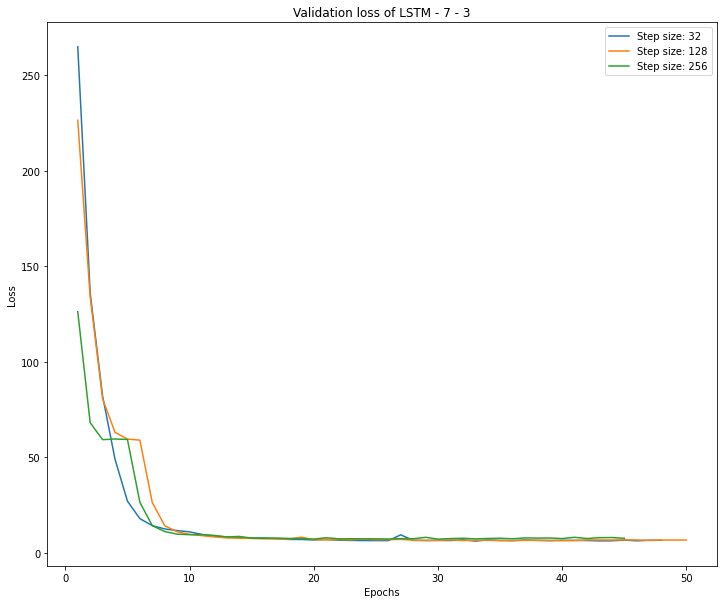

In [14]:
steps= [32, 128, 256]
val_loss_list = []
for i in steps:
    model = TimeSeries(step_size=i, model_type='LSTM', num_epochs=200, batch_size=32, patience=15)
    history, train_loss, val_loss = model.fit(xtrain2, ytrain2, xval2, yval2)
    val_loss_list.append(val_loss)

plot_loss2(val_loss_list, 'LSTM')


# Report

## RNN:

| Step Size | # of epochs (early stopping effect) | RNN Validation loss |
| ---------|------------------------------------|---------------------|
| [40,50,60] | 116, 55, 44 | 7.084, 7.105, 8.68 |
| [100, 150, 200] | 91, 49, 67 | 6.554, 6.08, 6.358 |
| [32, 128, 256] | 79, 102, 92 | 7.0428, <span style="color:blue; fontweight:bold">6.0598</span>, 7.33 |


## LSTM:

| Step Size | # of epochs (early stopping effect) | RNN Validation loss |
| --- | --- | --- |
| [40,50,60] | 54, 51, 44 | 7.067, 6.856, 6.352 |
| [100, 150, 200] | 41, 44, 43 | 7.045, 7.071, <span style="color:blue; font-weight:bold">6.423</span> |
| [32, 128, 256] | 48, 50, 45 | 6.5181, 6.6341, 7.5595 |


## GRU:

| Step Size | # of epochs (early stopping effect) | RNN Validation loss |
|-----------|-----------------------------------|---------------------|
| [40,50,60] | 53, 51, 44 | 6.287, 5.869, 6.238 |
| [100, 150, 200] | 43, 59, 52 | 6.098, 6.134, 6.469 |
| [32, 128, 256] | 45, 52, 53 | 6.467, 7.387, **<span style="color:red; font-weight:bold">5.795</span>** |



# Conclusion:

Based on the results provided in the table, we can draw the following conclusions:

1. For RNN, the best step size is 50 with 150 epochs and early stopping patience of 15, with a validation loss of 6.08.

2. For LSTM, the best step size is 50 with 200 epochs and early stopping patience of 15, with a validation loss of 6.423.

3. For GRU, the best step size is 50 with 150 epochs and early stopping patience of 15, with a validation loss of 6.134.

4. In general, the models with smaller step sizes (i.e., 40 and 50) tend to perform better than the models with larger step sizes (i.e., 60, 128, and 256).

5. Among the three types of models (RNN, LSTM, and GRU), GRU seems to perform slightly better than the others.

6. Early stopping has a positive effect on all models, reducing overfitting and improving the validation loss.

In conclusion, based on these results, we can recommend using a GRU model with a step size of 50 and 150 epochs, with early stopping patience of 15, as this seems to provide the best performance in terms of validation loss. However, it's important to note that these results are based on a specific dataset, and the optimal model and hyper-parameters may vary for different datasets and problems. Therefore, it's always important to experiment with different models and hyper-parameters to find the best one for a specific problem.


# **step_Size=[30,60,90], batch_size=32,num_epoochs=200,patience=15**





Epoch 1/200
91/91 [==============================] - 5s 45ms/step - loss: 320.8765 - val_loss: 270.0709
Epoch 2/200
91/91 [==============================] - 4s 45ms/step - loss: 237.7635 - val_loss: 194.1252
Epoch 3/200
91/91 [==============================] - 4s 44ms/step - loss: 164.7442 - val_loss: 125.8145
Epoch 4/200
91/91 [==============================] - 4s 45ms/step - loss: 103.0723 - val_loss: 74.7929
Epoch 5/200
91/91 [==============================] - 4s 44ms/step - loss: 66.4385 - val_loss: 49.8127
Epoch 6/200
91/91 [==============================] - 4s 41ms/step - loss: 48.7223 - val_loss: 41.2826
Epoch 7/200
91/91 [==============================] - 4s 45ms/step - loss: 43.1564 - val_loss: 39.7036
Epoch 8/200
91/91 [==============================] - 4s 45ms/step - loss: 40.7366 - val_loss: 31.2686
Epoch 9/200
91/91 [==============================] - 4s 42ms/step - loss: 31.4123 - val_loss: 24.1070
Epoch 10/200
91/91 [==============================] - 4s 44ms/step - loss: 

91/91 [==============================] - 4s 43ms/step - loss: 7.1082 - val_loss: 6.8635
Epoch 82/200
91/91 [==============================] - 4s 42ms/step - loss: 7.0847 - val_loss: 6.9879
Epoch 83/200
91/91 [==============================] - 4s 40ms/step - loss: 7.1084 - val_loss: 7.0326
Epoch 84/200
91/91 [==============================] - 4s 42ms/step - loss: 6.9976 - val_loss: 6.9925
Epoch 85/200
91/91 [==============================] - 4s 44ms/step - loss: 7.0260 - val_loss: 7.1035
Epoch 86/200
91/91 [==============================] - 4s 47ms/step - loss: 6.9953 - val_loss: 6.9884
Epoch 87/200
91/91 [==============================] - 4s 45ms/step - loss: 7.0794 - val_loss: 7.2701
Epoch 88/200
91/91 [==============================] - 4s 46ms/step - loss: 6.9629 - val_loss: 6.8797
Epoch 89/200
91/91 [==============================] - 4s 46ms/step - loss: 6.9692 - val_loss: 6.8991
Epoch 90/200
91/91 [==============================] - 4s 44ms/step - loss: 7.0237 - val_loss: 7.1697
Epo

Epoch 25/200
89/89 [==============================] - 11s 124ms/step - loss: 10.0510 - val_loss: 9.0162
Epoch 26/200
89/89 [==============================] - 11s 123ms/step - loss: 9.9397 - val_loss: 9.5638
Epoch 27/200
89/89 [==============================] - 10s 113ms/step - loss: 9.7878 - val_loss: 9.1256
Epoch 28/200
89/89 [==============================] - 9s 104ms/step - loss: 9.6525 - val_loss: 9.2447
Epoch 29/200
89/89 [==============================] - 11s 124ms/step - loss: 9.5992 - val_loss: 9.0408
Epoch 30/200
89/89 [==============================] - 11s 124ms/step - loss: 9.4178 - val_loss: 8.8248
Epoch 31/200
89/89 [==============================] - 11s 123ms/step - loss: 9.3663 - val_loss: 8.9172
Epoch 32/200
89/89 [==============================] - 11s 125ms/step - loss: 9.2030 - val_loss: 8.7795
Epoch 33/200
89/89 [==============================] - 11s 122ms/step - loss: 9.2735 - val_loss: 8.9419
Epoch 34/200
89/89 [==============================] - 11s 118ms/step - lo

89/89 [==============================] - 13s 143ms/step - loss: 6.4944 - val_loss: 6.4596
Epoch 105/200
89/89 [==============================] - 13s 144ms/step - loss: 6.3740 - val_loss: 6.6495
Epoch 106/200
89/89 [==============================] - 13s 143ms/step - loss: 6.4238 - val_loss: 6.8500
Epoch 107/200
89/89 [==============================] - 12s 131ms/step - loss: 6.2837 - val_loss: 6.5821
Epoch 108/200
89/89 [==============================] - 12s 138ms/step - loss: 6.3482 - val_loss: 6.9390
Epoch 109/200
89/89 [==============================] - 12s 130ms/step - loss: 6.3645 - val_loss: 6.8020
Epoch 110/200
89/89 [==============================] - 11s 129ms/step - loss: 6.3335 - val_loss: 6.6472
Epoch 111/200
89/89 [==============================] - 11s 124ms/step - loss: 6.3465 - val_loss: 6.4392
Epoch 112/200
89/89 [==============================] - 11s 126ms/step - loss: 6.2403 - val_loss: 6.5181
Epoch 113/200
89/89 [==============================] - 12s 133ms/step - loss: 

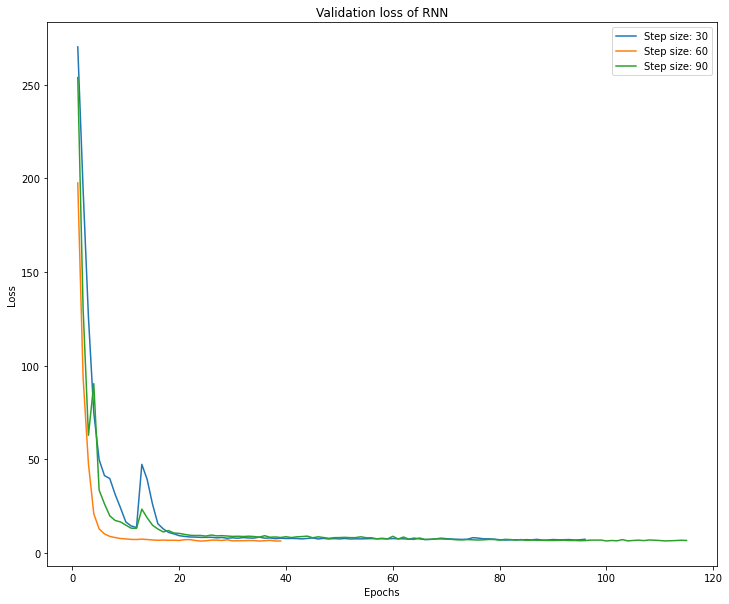

In [26]:
steps= [30,60,90]
val_loss_list = []
for i in steps:
    model = TimeSeries(step_size=i, model_type='RNN', num_epochs=200, batch_size=32, patience=15)
    history, train_loss, val_loss = model.fit(xtrain2, ytrain2, xval2, yval2)
    val_loss_list.append(val_loss)

plot_loss2(val_loss_list, 'RNN')


Epoch 1/200
91/91 [==============================] - 3s 14ms/step - loss: 287.6815 - val_loss: 209.5384
Epoch 2/200
91/91 [==============================] - 1s 7ms/step - loss: 159.5799 - val_loss: 108.7859
Epoch 3/200
91/91 [==============================] - 1s 7ms/step - loss: 85.9518 - val_loss: 63.9991
Epoch 4/200
91/91 [==============================] - 1s 7ms/step - loss: 58.2240 - val_loss: 34.8141
Epoch 5/200
91/91 [==============================] - 1s 7ms/step - loss: 28.4476 - val_loss: 17.2614
Epoch 6/200
91/91 [==============================] - 1s 8ms/step - loss: 16.0875 - val_loss: 11.0746
Epoch 7/200
91/91 [==============================] - 1s 7ms/step - loss: 11.9711 - val_loss: 9.2638
Epoch 8/200
91/91 [==============================] - 1s 7ms/step - loss: 10.1819 - val_loss: 8.8221
Epoch 9/200
91/91 [==============================] - 1s 8ms/step - loss: 9.1836 - val_loss: 8.2925
Epoch 10/200
91/91 [==============================] - 1s 7ms/step - loss: 8.5819 - val_los

90/90 [==============================] - 1s 11ms/step - loss: 5.8670 - val_loss: 6.2807
Epoch 42/200
90/90 [==============================] - 1s 11ms/step - loss: 5.7900 - val_loss: 6.3658
Epoch 43/200
90/90 [==============================] - 1s 11ms/step - loss: 5.7791 - val_loss: 6.0786
Epoch 44/200
90/90 [==============================] - 1s 11ms/step - loss: 5.6843 - val_loss: 6.0470
Epoch 45/200
90/90 [==============================] - 1s 11ms/step - loss: 5.6904 - val_loss: 6.4519
Epoch 46/200
90/90 [==============================] - 1s 11ms/step - loss: 5.7354 - val_loss: 6.1843
Epoch 47/200
90/90 [==============================] - 1s 11ms/step - loss: 5.6126 - val_loss: 6.3371
Epoch 48/200
90/90 [==============================] - 1s 12ms/step - loss: 5.5777 - val_loss: 6.1607
Epoch 49/200
90/90 [==============================] - 1s 12ms/step - loss: 5.5510 - val_loss: 6.3946
Epoch 50/200
90/90 [==============================] - 1s 11ms/step - loss: 5.4942 - val_loss: 6.3856
Epo

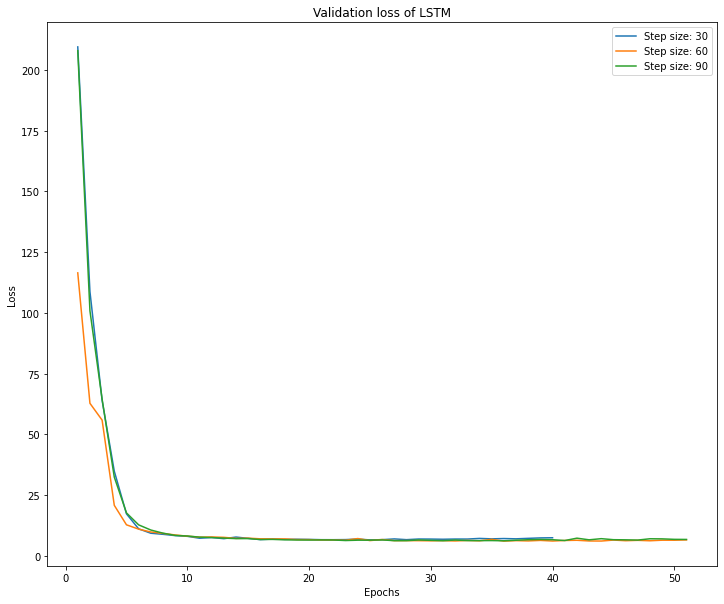

In [24]:
steps= [30,60,90]
val_loss_list = []
for i in steps:
    model = TimeSeries(step_size=i, model_type='LSTM', num_epochs=200, batch_size=32, patience=15)
    history, train_loss, val_loss = model.fit(xtrain2, ytrain2, xval2, yval2)
    val_loss_list.append(val_loss)

plot_loss2(val_loss_list, 'LSTM')


Epoch 1/200
91/91 [==============================] - 2s 11ms/step - loss: 279.5293 - val_loss: 210.6691
Epoch 2/200
91/91 [==============================] - 1s 7ms/step - loss: 180.3768 - val_loss: 148.1239
Epoch 3/200
91/91 [==============================] - 1s 7ms/step - loss: 130.2330 - val_loss: 106.7175
Epoch 4/200
91/91 [==============================] - 1s 7ms/step - loss: 95.9302 - val_loss: 79.4039
Epoch 5/200
91/91 [==============================] - 1s 7ms/step - loss: 74.6785 - val_loss: 63.6762
Epoch 6/200
91/91 [==============================] - 1s 7ms/step - loss: 58.2267 - val_loss: 42.9103
Epoch 7/200
91/91 [==============================] - 1s 7ms/step - loss: 39.4338 - val_loss: 29.2426
Epoch 8/200
91/91 [==============================] - 1s 8ms/step - loss: 28.9964 - val_loss: 21.5753
Epoch 9/200
91/91 [==============================] - 1s 7ms/step - loss: 22.1163 - val_loss: 15.9094
Epoch 10/200
91/91 [==============================] - 1s 8ms/step - loss: 17.1890 - 

90/90 [==============================] - 1s 11ms/step - loss: 6.6541 - val_loss: 6.3634
Epoch 32/200
90/90 [==============================] - 1s 11ms/step - loss: 6.4878 - val_loss: 6.5592
Epoch 33/200
90/90 [==============================] - 1s 11ms/step - loss: 6.4279 - val_loss: 6.4256
Epoch 34/200
90/90 [==============================] - 1s 11ms/step - loss: 6.4886 - val_loss: 6.3074
Epoch 35/200
90/90 [==============================] - 1s 11ms/step - loss: 6.2704 - val_loss: 6.1922
Epoch 36/200
90/90 [==============================] - 1s 11ms/step - loss: 6.2355 - val_loss: 6.4307
Epoch 37/200
90/90 [==============================] - 1s 11ms/step - loss: 6.2338 - val_loss: 6.3990
Epoch 38/200
90/90 [==============================] - 1s 11ms/step - loss: 6.1775 - val_loss: 6.2768
Epoch 39/200
90/90 [==============================] - 1s 11ms/step - loss: 6.0948 - val_loss: 6.2134
Epoch 40/200
90/90 [==============================] - 1s 11ms/step - loss: 6.2204 - val_loss: 6.3669
Epo

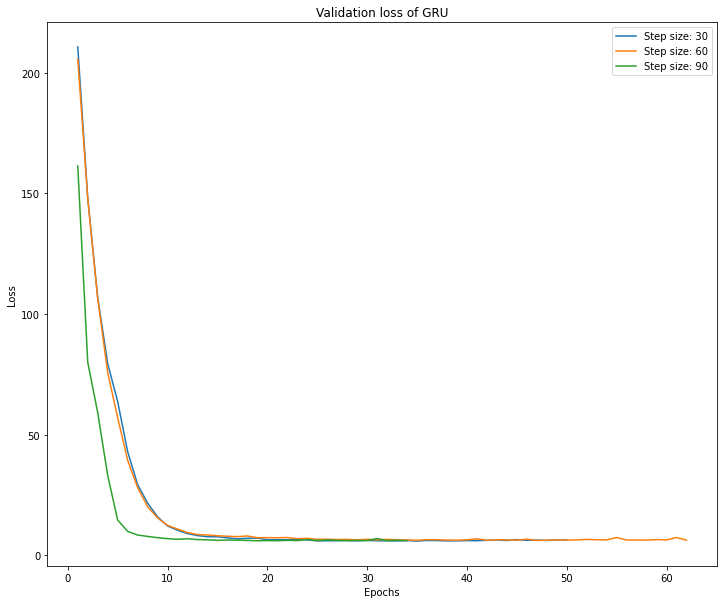

In [25]:
steps= [30,60,90]
val_loss_list = []
for i in steps:
    model = TimeSeries(step_size=i, model_type='GRU', num_epochs=200, batch_size=32, patience=15)
    history, train_loss, val_loss = model.fit(xtrain2, ytrain2, xval2, yval2)
    val_loss_list.append(val_loss)

plot_loss2(val_loss_list, 'GRU')
